In [37]:
import torch
from torch.nn import MSELoss, Module
import spacy
from nltk.corpus import wordnet as wn
import numpy as np
import pandas as pd
import json

In [2]:
def get_batches(data, batch_size):
    
    no_of_batches = len(data) // batch_size
    
    for n in range(0, len(data), no_of_batches):
        
        try:
            
            x1 = data.sent_1.iloc[n:n + no_of_batches].values
            x2 = data.sent_2.iloc[n:n + no_of_batches].values
            Y = data.score.iloc[n:n + no_of_batches].values
        
        except IndexError:
            
            x1 = data.sent_1.iloc[n:].values
            x2 = data.sent_2.iloc[n:].values
            Y = data.score.iloc[n:].values
    
    yield x1, x2, Y

In [41]:
class TextSimilarity():
    
    def __init__(self, tags_dict = None, correlation_matrix = None):
        
        self._tags = self._get_tags_dict() if tags_dict is None else tags_dict
        self._no_of_tags = len(self._tags)
#         TODO: initialize weights to identity, random, zeros
        self._tag_correlation_matrix = np.identity(self._no_of_tags) if correlation_matrix is None else correlation_matrix
        self._parser = spacy.load("en")
        
    def _get_tags_dict(self):
        
        with open("data/tags.json","r") as fl:
            tags = json.load(fl)
            
        return tags
    
    def _similarity_word(self, pair_A, pair_B):

        #getting head and dependent texts 
        head_a, head_b = pair_A[0].text, pair_B[0].text
        dep_a, dep_b = pair_A[2].text, pair_B[2].text

        if head_a == head_b:
            head = 1
        else:
            try:
                #WordNet synsets for heads
                head_a, head_b = wn.synsets(head_a)[0], wn.synsets(head_b)[0]
                
#                 TODO:Change similarity method
                #path based similarity (Li et. al) for head
                head = head_a.path_similarity(head_b)

                head = 0 if head is None else head  

            except Exception:
                head = 0

        if dep_a == dep_b:
            dep = 1
        else:
            try:
                #WordNet synsets for dependent
                dep_a, dep_b = wn.synsets(dep_a)[0], wn.synsets(dep_b)[0]
                
#                 TODO:Change similarity method
                #path based similarity (Li et. al) for dependent
                dep = dep_a.path_similarity(dep_b)

                dep = 0 if dep is None else dep

            except Exception:
                dep = 0     

        return head + dep

    def _similarity_tag(self, tag_a, tag_b):
        
        tag_a_id, tag_b_id = self._tags[tag_a], self._tags[tag_b] 
        score = self._tag_correlation_matrix[tag_a_id,tag_b_id]
        
        return score
    
    def semantic_similarity(self, documents_1, documents_2):
        
        #checking the sizes of both documents
        assert len(documents_1) == len(documents_2), "Size of both lists should be same."
        
        #scores vector
        scores = torch.zeros([len(documents_1),],dtype=torch.double)
        
        i = 0
            
        for document_1, document_2 in zip(documents_1,documents_2):
            
            #parsing documets using spaCy English language parser
            tokens_1,tokens_2 = self._parser(document_1), self._parser(document_2)

            #seperating dependency pairs and tags from tokens
            pairs_1 = [(token.head,token.dep_,token) for token in tokens_1]
            pairs_2 = [(token.head,token.dep_,token) for token in tokens_2]

            score = 0

            #calculating score 
            for pair_A in pairs_1:

                for pair_B in pairs_2:

                    score += self._similarity_word(pair_A, pair_B) * self._similarity_tag(pair_A[1], pair_B[1])

            #averaging score 
            #score = score / (len(tokens_1) + len(tokens_2))
            
            score = torch.sigmoid(score)
            
            scores[i] += score
            
            i += 1

        return scores 

In [42]:
sim = TextSimilarity()
sim._tag_correlation_matrix = torch.from_numpy(sim._tag_correlation_matrix)
sim._tag_correlation_matrix.requires_grad = True
sent_1 = ["he is boy","it is dog"]
sent_2 = ["he is girl","it is cat"]
score = sim.semantic_similarity(sent_1,sent_2)
print(score)
sim._tag_correlation_matrix

tensor([0.9943, 0.9945], dtype=torch.float64, grad_fn=<CopySlices>)


tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]],
       dtype=torch.float64, requires_grad=True)

In [43]:
loss = MSELoss()
optimizer = torch.optim.Adam([sim._tag_correlation_matrix], lr=0.001)
target = torch.DoubleTensor([.8,.7])
target.requires_grad = True
loss_score = loss(score, target)
print(loss_score.item())
loss_score.backward()
print(sim._tag_correlation_matrix.grad)
optimizer.step()
sim._tag_correlation_matrix

0.12450200147407048
tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0108, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
       dtype=torch.float64)


tensor([[1.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.9990, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 1.0000]],
       dtype=torch.float64, requires_grad=True)

In [44]:
def train(data, model, epochs = 25, lr = 0.001, validation_thresh = 0.2, batch_size = 10, print_every = 5):
    
    model._tag_correlation_matrix = torch.from_numpy(model._tag_correlation_matrix)
    model._tag_correlation_matrix.requires_grad = True
    
    criterion = MSELoss()
    optimizer = torch.optim.Adam([model._tag_correlation_matrix], lr=lr)
    
    thresh = int(validation_thresh * len(data))
    
    train_data = data.iloc[:thresh]
    valid_data = data.iloc[thresh:]
    
    train_losses = []
    valid_losses = []
    count = 0
    
    for epoch in range(epochs):
        
        losses = []
        
        for x1, x2, Y in get_batches(train_data, batch_size):
            
            count += 1
        
            scores = model.semantic_similarity(x1, x2)
            
            Y = torch.DoubleTensor(Y)
            
            loss = criterion(scores, Y)
            
            losses.append(loss.item())
            
            optimizer.zero_grad()
            
            loss.backward()
            
            optimizer.step()
            
            
            if count % print_every == 0:
                
                train_losses.append(np.mean(losses))
                losses = []
                
                for x1, x2, Y in get_batches(valid_data, batch_size):
                    
                    scores = model.semantic_similarity(x1, x2)
                    
                    Y = torch.DoubleTensor(Y)
                    
                    loss = criterion(scores, Y)

                    losses.append(loss.item())
                    
                valid_losses.append(np.mean(losses))
                
                print(f"{count} {epoch}/{epochs}\ttraining loss:{train_losses[-1]}\tvalididation loss:{valid_losses[-1]}")
    
    return train_losses,valid_losses

In [45]:
data = pd.read_csv("data/STS_Data1213.csv",index_col=None)
data.score = data.score/5.0
data.head(10)

,Unnamed: 0,Unnamed: 0.1,sent_1,sent_2,score
0,0,0.0,The problem likely will mean corrective change...,He said the problem needs to be corrected befo...,0.88
1,1,1.0,The technology-laced Nasdaq Composite Index .I...,The broad Standard & Poor's 500 Index .SPX inc...,0.16
2,2,2.0,"""It's a huge black eye,"" said publisher Arthur...","""It's a huge black eye,"" Arthur Sulzberger, th...",0.72
3,3,3.0,SEC Chairman William Donaldson said there is a...,"""I think there's a building confidence that th...",0.68
4,4,4.0,Vivendi shares closed 1.9 percent at 15.80 eur...,"In New York, Vivendi shares were 1.4 percent d...",0.28
5,5,5.0,Myanmar's pro-democracy leader Aung San Suu Ky...,Myanmar's pro-democracy leader Aung San Suu Ky...,0.92
6,6,6.0,"Darren Dopp, a Spitzer spokesman, declined to ...","John Heine, a spokesman for the commission in ...",0.28
7,7,7.0,Bremer said one initiative is to launch a US$7...,Bremer said he would launch a $70-million prog...,0.72
8,8,8.0,"In afternoon trading in Europe, France's CAC-4...","In Europe, France's CAC-40 rose 1.3 percent, B...",0.40
9,9,9.0,He later learned that the incident was caused ...,He later found out the alarming incident had b...,1.00


In [46]:
model = TextSimilarity()
thresh = int(0.8 * len(data))

train_data = data.iloc[:thresh]
test_data = data.iloc[thresh:]

In [47]:
#TODO: change epoch, lr, batch_size
epoch = 100
lr = 0.01
batch_size = 10

train_losses,valid_losses = train(train_data, model, epochs=epoch, lr=lr, batch_size = batch_size)

5 4/100	training loss:0.15783744671054073	valididation loss:0.17372434650858132
10 9/100	training loss:0.15778586422124907	valididation loss:0.16812720797087055
15 14/100	training loss:0.1575725157812162	valididation loss:0.1623273993875429
20 19/100	training loss:0.1566082453650173	valididation loss:0.1560216944725809
25 24/100	training loss:0.15215995395450052	valididation loss:0.1494623673376299
30 29/100	training loss:0.13871893176631836	valididation loss:0.14828524251485067
35 34/100	training loss:0.1258178725722612	valididation loss:0.15135618999210748
40 39/100	training loss:0.11291896791796821	valididation loss:0.15502419756011396
45 44/100	training loss:0.10982735518368265	valididation loss:0.15668704774587988
50 49/100	training loss:0.08439459256154673	valididation loss:0.15199080337690085
55 54/100	training loss:0.06556488981037116	valididation loss:0.14687903424821075
60 59/100	training loss:0.06085313400822855	valididation loss:0.147698377809606
65 64/100	training loss:0.0

In [48]:
model._tag_correlation_matrix

tensor([[ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.8368,  0.0000,  ..., -0.0904, -0.3619, -0.2809],
        [ 0.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.5312,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.5633]],
       dtype=torch.float64, requires_grad=True)

In [49]:
test_Y = test_data.score
scores = model.semantic_similarity(test_data.sent_1, test_data.sent_2)

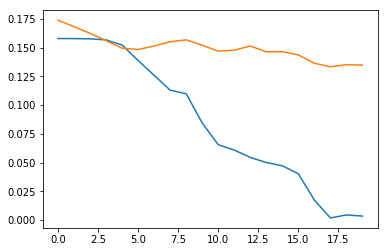

In [50]:
import matplotlib.pyplot as plt

plt.plot(train_losses)
plt.plot(valid_losses)

In [53]:
test_Y = torch.DoubleTensor(test_Y.values)
loss(scores,test_Y)

tensor(0.2543, dtype=torch.float64, grad_fn=<MseLossBackward>)